In [ ]:

import os, re, time
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import tiktoken
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from openai import OpenAI

# --- LiteLLM client ---
client = OpenAI(
    api_key="",
    base_url="https://litellmproxy.osu-ai.org/"
)
OPENAI_MODEL = "GPT-4o"

# --- Load your dataset ---
df = pd.read_csv("infoevents1.csv")
df = df.reset_index(drop=True)
print(f"Loaded {len(df)} rows")

# --- Ensure output cols exist ---
for col in ["category", "confidence", "explanation", "raw_llm_output", "tokens_used"]:
    if col not in df.columns:
        df[col] = None

################################################################################################################
PDF_PROMPT = """You are an expert consultant in the automobile industry. I would like your help classifying a set
of investments made by automakers (OEMs).

In each investment, an OEM invests into a target company. Focus only on the target company’s main business activity, not the automaker itself.
The target offers a product or service that may fall into one of three categories:

1. The product or service is directly related to the traditional technology: the internal
combustion engine vehicle (ICEV). This may include but is not restricted to:
• Internal-combustion powertrain components, such as motor, diesel engines, exhaust
systems.
• Manufacturing of the entire ICEV, including cars, trucks, scooters, motorcycles, or
other vehicles.
• Processing of raw materials or upstream products clearly related to ICEV (e.g., oil,
gasoline).
• Energy or infrastructure primarily serving ICE vehicles (e.g., fuel stations, oil refining).

2. The product or service is directly related to the alternative technology: the electric
engine vehicle (EEV). This may include electric cars, trucks, scooters, motorcycles, or
other vehicles. This may include but is not restricted to:
• Electric powertrain components, such as battery.
• Manufacturing of the entire EEV, including cars, trucks, scooters, motorcycles, or
other vehicles.
• Manufacturing of products or technologies related to alternative energy only if
specifically used in EEVs (e.g., hydrogen fuel cell vehicles).
• Processing of raw materials clearly used for EEV technologies (e.g., lithium).
• Energy, charging, or infrastructure that primarily supports EVs.

3. The product or service is directly related to neither ICEV nor EV. This may include both
upstream products/services broadly applicable and downstream products/services
broadly applicable. This may include but is not restricted to:
• Raw materials or general components not tied to a specific type of powertrain.
• Industrial machinery not tied to a specific powertrain.
• Software not tied to a specific powertrain.
• Distribution channels, marketing, logistic, and other general-purpose services not
tied to a specific powertrain.
• Any service, software, or investment with no explicit link to vehicles or mobility technology.

In especially ambiguous cases, you may consider following this decision tree:

1. Does the target manufacture entire vehicles?
o If yes, choose Category 1 or 2.
o If “manufactures motor vehicles” and no EEV-specific language, choose Category 1.
o If manufactures EEV, choose Category 2.
o If both ICEV and EV are mentioned, but EV is emphasized, or represents the main focus, choose Category 2.

2. Is the product/service directly related to the powertrain?
o If yes, choose Category 1 or 2.
o If it manufactures internal combustion engines or related components, choose
Category 1.
o If manufactures electric engine or related components, choose Category 2.

3. If not manufacturing whole vehicle or powertrain-related products/services, is the
product/service either upstream or downstream?
o If related to gasoline, diesel, or oil, choose Category 1.
o If related to EEV marketing or EEV-focused import/export, choose Category 2.
o If related to other type of alternative energy used specifically in electric engine
vehicles (e.g., hydrogen fuel cell electric vehicles), choose Category 2.
o If general/unspecified or not clearly tied to ICEV or EV, choose Category 3.

Please consider the following information about the target company:

- Description: \"\"\"{description}\"\"\"
- Deal Synopsis: \"\"\"{synopsis}\"\"\"
- Date Announced: {date}

Please:

- Classify the product or service into one of the three categories (1, 2, or 3)
- Choose only one category — do not output multiple categories or ranges.
- Provide a brief explanation (20–50 words)
- Rate your confidence in the classification on a scale from 1 (no confidence) to 100 (full confidence)

Respond in the following format:

Category: [1/2/3]
Explanation: [your explanation]
Confidence: [number]

Please make sure that category and explanation are internally consistent.
Double-check your reasoning to ensure the explanation clearly supports the chosen category before finalizing."""
#################################################################################################################

# --- Classification function (unchanged) ---
def get_openai_classification(text_description, deal_synopsis, deal_year, row_sdcdealno=None):
    system_message_content = PDF_PROMPT
    user_message_content = PDF_PROMPT.format(
        description=text_description,
        synopsis=deal_synopsis,
        date=int(deal_year) if str(deal_year).isdigit() else deal_year
    )

    messages = [
        {"role": "system", "content": system_message_content},
        {"role": "user", "content": user_message_content}
    ]

    try:
        resp = client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=messages,
            temperature=0,
            top_p=0.3,
            max_tokens=250
        )
        content = resp.choices[0].message.content.strip()

        cat, conf, expl = "NA", 0, ""
        if content:
            cat_m = re.search(r"Category:\s*([123])", content, re.I)
            conf_m = re.search(r"Confidence:\s*([0-9]{1,3})", content, re.I)
            exp_m = re.search(r"Explanation:\s*(.*)", content, re.I | re.DOTALL)

            if cat_m: cat = cat_m.group(1)
            if conf_m: conf = int(conf_m.group(1))
            if exp_m:
                expl = exp_m.group(1).split("Confidence:")[0].strip()

        return {
            "category": cat,
            "confidence": conf,
            "explanation": expl,
            "raw_output": content
        }
    except Exception as e:
        return {"category": "error", "confidence": 0, "explanation": str(e), "raw_output": str(e)}

# --- Tokenizer setup (unchanged) ---
try:
    enc = tiktoken.encoding_for_model(OPENAI_MODEL)
except:
    enc = tiktoken.get_encoding("cl100k_base")

# --- Main loop ---
for i, row in tqdm(df.iterrows(), total=len(df), desc="Classifying"):
    desc = str(row.get("targetbusinessdescription", ""))
    syn  = str(row.get("dealsynopsis", ""))
    year = row.get("deal_year", "")

    sys_txt = PDF_PROMPT
    usr_txt = PDF_PROMPT.format(description=desc, synopsis=syn, date=year)
    df.at[i, "tokens_used"] = len(enc.encode(sys_txt + usr_txt))

    result = get_openai_classification(desc, syn, year, row.get("sdcdealno", "N/A"))
    df.at[i, "category"]      = result["category"]
    df.at[i, "confidence"]    = result["confidence"]
    df.at[i, "explanation"]   = result["explanation"]
    df.at[i, "raw_llm_output"]= result["raw_output"]

    # Autosave every 50 rows (safe, non-intrusive)
    if (i + 1) % 50 == 0:
        df.to_csv("Infoevents1_autosave.csv", index=False)
        print(f"Autosaved progress at row {i + 1}")

    time.sleep(1.1)

# --- Save results ---
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file = f"Infoevents1zeroshot_predictions_{ts}.csv"
df.to_csv(out_file, index=False)
print(f"Saved {out_file}")
print(f"Completed {len(df)} rows successfully")


Pred rows: 1200  | pred valid 1/2/3: 1200
Unique pred deal_ids: 1200  | valid 1/2/3: 1200
Solution rows: 254  | unique sol deal_ids: 254
Merged rows: 254


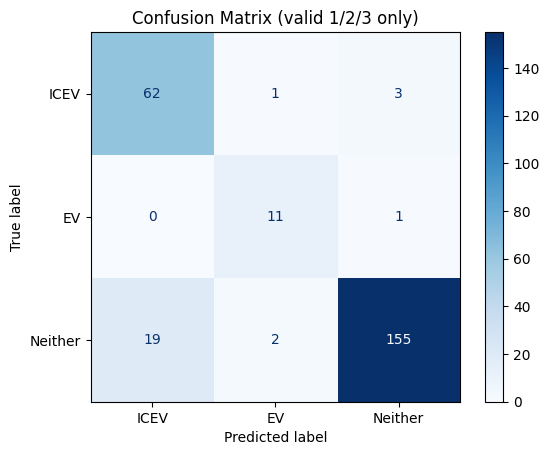

Accuracy: 0.8976377952755905
              precision    recall  f1-score   support

        ICEV     0.7654    0.9394    0.8435        66
          EV     0.7857    0.9167    0.8462        12
     Neither     0.9748    0.8807    0.9254       176

    accuracy                         0.8976       254
   macro avg     0.8420    0.9122    0.8717       254
weighted avg     0.9115    0.8976    0.9004       254



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# --- paths (adjust if needed) ---
pred_path = "Infoevents1zeroshot_predictions_20251104_205334.csv"
sol_path  = "infoevents1sol.xlsx"

# --- load ---
df_pred = pd.read_csv(pred_path)
sol_df  = pd.read_excel(sol_path)

# --- normalize id columns ---
# predictions: prefer sdcdealno -> deal_id
if "deal_id" in df_pred.columns:
    pass
elif "sdcdealno" in df_pred.columns:
    df_pred = df_pred.rename(columns={"sdcdealno": "deal_id"})
else:
    raise ValueError("Pred file missing 'sdcdealno'/'deal_id' column. Columns: " + ", ".join(df_pred.columns))

# solutions: prefer sdcdealno -> deal_id
if "deal_id" in sol_df.columns:
    pass
elif "sdcdealno" in sol_df.columns:
    sol_df = sol_df.rename(columns={"sdcdealno": "deal_id"})
else:
    raise ValueError("Solutions file missing 'sdcdealno'/'deal_id'. Columns: " + ", ".join(sol_df.columns))

# --- coerce prediction categories to numeric and keep only 1/2/3 ---
df_pred["category_num"] = pd.to_numeric(df_pred["category"], errors="coerce")
df_pred_valid = df_pred[df_pred["category_num"].isin([1, 2, 3])].copy()

# --- diagnostics before merge ---
print("Pred rows:", len(df_pred), " | pred valid 1/2/3:", len(df_pred_valid))
print("Unique pred deal_ids:", df_pred["deal_id"].nunique(), " | valid 1/2/3:", df_pred_valid["deal_id"].nunique())
print("Solution rows:", len(sol_df), " | unique sol deal_ids:", sol_df["deal_id"].nunique())
if len(df_pred_valid) == 0:
    print("All predictions are NA/invalid (not in {1,2,3}). Nothing to evaluate.")

# --- merge on deal_id ---
merged = pd.merge(
    df_pred_valid[["deal_id", "category_num"]],
    sol_df[["deal_id", "categorysol"]],
    on="deal_id",
    how="inner"
)

print("Merged rows:", len(merged))
if len(merged) == 0:
    # help troubleshoot
    pred_ids = set(df_pred_valid["deal_id"].astype(str))
    sol_ids  = set(sol_df["deal_id"].astype(str))
    inter    = pred_ids & sol_ids
    print("Overlap in IDs:", len(inter))
    sample_pred_only = list(pred_ids - sol_ids)[:5]
    sample_sol_only  = list(sol_ids - pred_ids)[:5]
    print("Sample pred-only IDs:", sample_pred_only)
    print("Sample sol-only IDs:", sample_sol_only)

# --- proceed only if we have rows ---
if len(merged) > 0:
    # keep only solution labels 1/2/3
    merged = merged[merged["categorysol"].isin([1, 2, 3])].copy()
    if len(merged) == 0:
        print("After filtering solution labels to {1,2,3}, no rows remain.")
    else:
        y_true = merged["categorysol"].astype(int).to_numpy()
        y_pred = merged["category_num"].astype(int).to_numpy()

        # Confusion matrix (works even if a class is missing in preds; we force labels)
        labels = [1, 2, 3]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ICEV", "EV", "Neither"])
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix (valid 1/2/3 only)")
        plt.show()

        # Classification report (force labels + names; handle zero divisions)
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print(classification_report(
            y_true, y_pred,
            labels=labels,
            target_names=["ICEV", "EV", "Neither"],
            digits=4,
            zero_division=0
        ))
else:
    print("No rows to evaluate. See diagnostics above.")


In [ ]:
import pandas as pd

# Load the original and the new prediction file
df_orig = pd.read_csv("infoevents1.csv")
df_pred = pd.read_csv("Infoevents1zeroshot_predictions_20251104_205334.csv")  # 👈 replace filename here

# Normalize keys
for df in [df_orig, df_pred]:
    for col in ["n", "sdcdealno"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

# Row count check
print("=== Row Counts ===")
print(f"Original rows : {len(df_orig)}")
print(f"Predicted rows: {len(df_pred)}")

# Missing ID check
missing = set(df_orig["sdcdealno"]) - set(df_pred["sdcdealno"])
extra   = set(df_pred["sdcdealno"]) - set(df_orig["sdcdealno"])
print("\n=== Key Mismatch Check ===")
print(f"Missing from predictions: {len(missing)} → {list(missing)[:5]}")
print(f"Extra in predictions    : {len(extra)} → {list(extra)[:5]}")

# Order check
same_order = df_orig["sdcdealno"].tolist() == df_pred["sdcdealno"].tolist()
print(f"\n=== Order Consistency ===")
print(f"Same order as original: {same_order}")

# Optional: show any last mismatched rows
if not same_order:
    misaligned = df_orig["sdcdealno"].compare(df_pred["sdcdealno"])
    print("\nMismatched indices (if any):")
    print(misaligned.head())


=== Row Counts ===
Original rows : 1200
Predicted rows: 1200

=== Key Mismatch Check ===
Missing from predictions: 0 → []
Extra in predictions    : 0 → []

=== Order Consistency ===
Same order as original: True
